In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import hilbert

import sys
import os

#get current directory (the directory where this notebook is located)
cdir = os.getcwd()

#get the grandmother directory (two levels up)
grandma_dir = os.path.abspath(os.path.join(cdir, os.pardir, os.pardir))

# Construct the path to the py directory
py_dir = os.path.join(grandma_dir, 'py')

for dir in [py_dir]:
    #include function-directories to the system path
    if dir not in sys.path:
        sys.path.append(dir)
        print(f"Included {dir} in sys.path")

#verify  directories
print(f"Current directory: {cdir}")
print(f"Grandmother directory: {grandma_dir}")
print(f"System path: {sys.path}")


import continuum1d as continuum1d
c1d = continuum1d.continuum1d()

from params import setParams
from analysis import computeFPs, checkFixPtsStability, violationType, a_jkValues, lmbd
from turings import checkStability

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

1d Model initialised.


In [2]:
#ee = 0.34
#ii = -0.2

#ee = -0.49
#ii = -0.8

ee = -0.3
ii = -0.75

params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 15*1000, 'mu_a': 0.4, 'beta_a': 10, 'n': 526}

ps = setParams(params)
fps = computeFPs(ps)
stab = checkFixPtsStability(fps, ps)

k=np.linspace(-3,3,51)

a_ee, a_ei, a_ie, a_ii = a_jkValues(fps[-1], ps)

print('fixed points %s ' %str(fps))
print('with (mass) stability %s'  %str(stab))

fixed points [[0.22389562 0.24170095]] 
with (mass) stability [0]


In [3]:
fp = fps[0]
checkStability(k, fp, ps)

(1, 1, 0)

In [4]:
ue, ui = c1d.run(ps, itype='inte_adaptation', fp=fp)

In [5]:
fix_time_step = -1000
fix_space_node0 = 10
fix_space_node1 = 70
fix_space_node2 = 120
cmap = 'summer'

Text(0, 0.5, 'space')

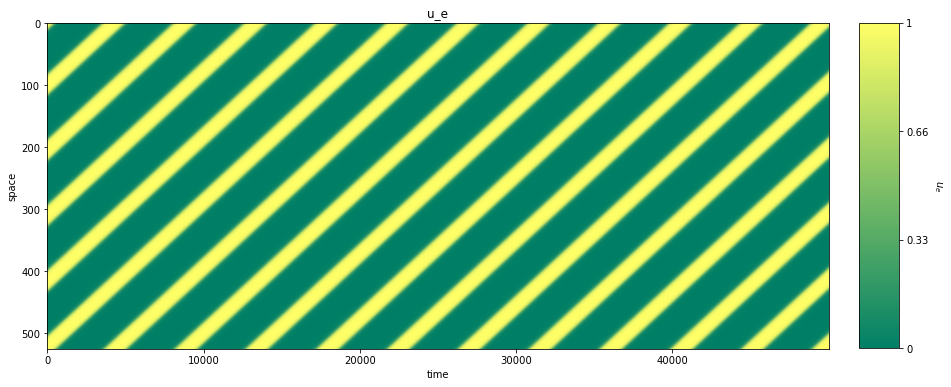

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

pos = ax.imshow(ue.T[:,-50000:], vmin=0, vmax=1, aspect='auto', cmap=cmap)
colors = ['black', 'dimgray', 'silver']

#for idx, fix_space_node in enumerate([fix_space_node0, fix_space_node1, fix_space_node2]):
#    ax.plot(np.linspace(fix_space_node, fix_space_node, len(ps.time)),
#            c=colors[idx], ls='solid', lw=3)
#ax.plot(np.linspace(ps.time[fix_time_step]*10, ps.time[fix_time_step]*10, len(ps.x)), 
#        np.linspace(0, ps.n-1, ps.n),
#        c='black', ls='dashed', lw=3)

ax.set_title(label='u_e')

cbar_ticks=np.linspace(0,1,4)
cb_ax = fig.add_axes([.93,.126,.04,.754])
cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel(r'$u_e$', rotation=-90, va="bottom")
cbar.ax.set_yticklabels([0, 0.33, 0.66, 1])

ax.set_xlabel('time')
ax.set_ylabel('space')

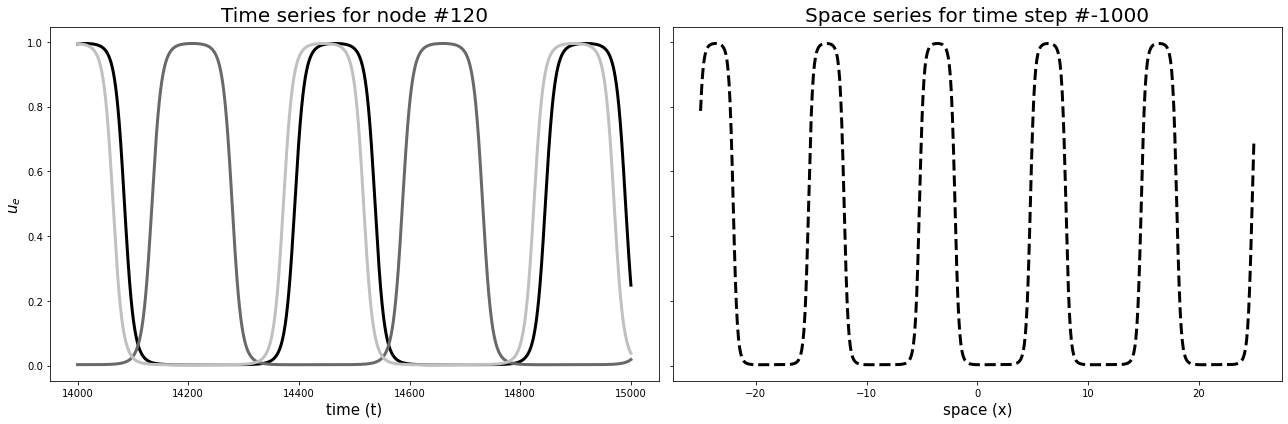

In [7]:
#plot cross section along one fix time-step and space step
space = np.linspace(-25, 25, len(ps.x))
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(18,6), sharey=True)

for idx, fix_space_node in enumerate([fix_space_node0, fix_space_node1, fix_space_node2]):
    ax0.plot(ps.time[-10000:], ue.T[fix_space_node,-10000:],
             c=colors[idx], ls='solid', lw=3)
ax1.plot(space, ue.T[:,fix_time_step],
         c='black', ls='dashed', lw=3)

ax0.set_title('Time series for node #%i' %fix_space_node, fontsize=20)
ax1.set_title('Space series for time step #%i' %fix_time_step, fontsize=20)

ax0.set_xlabel('time (t)', fontsize=15)
ax0.set_ylabel(r'$u_e$', fontsize=15)

ax1.set_xlabel('space (x)', fontsize=15)

plt.tight_layout()

In [8]:
ue.shape

(150001, 526)

In [9]:
def hilbert_trafo_nd(signal, axis=0):
    """simply the call of the off-shelf implementation to not have to calculate it for every feature individually.
    INPUT:
    :signal: (n,m)-dimensional array of real-valued signal. 
    We have activity=(rows,columns)=(time,nodes) -> default-axis=0.
    
    :output: (n,m)-dimensional array analytical representation of signal
    """
    from scipy.signal import hilbert
    
    #compute Hilbert Transform for analytical signal representation
    #ue.shape = (time-steps+1, number of nodes)
    #i.e. rows=time, columns=node -> want hilbert trafo w.r.t. time => axis=0
    ana_signal = hilbert(signal, axis=axis)
    
    return(ana_signal)

def hilbert_trafo_1d(signal):
    """simply the call of the off-shelf implementation to not have to calculate it for every feature individually"""
    from scipy.signal import hilbert
    
    ana_signal = hilbert(signal)
    
    return(ana_signal)

def inst_phase(signal):
    """Compute the instantaneous phase per time step per node."""
    
    #without unwrapping?
    inst_phase = np.unwrap(np.angle(signal))
    
    #inst_phase = np.unwrap(np.angle(signal))
    
    return inst_phase

def inst_frequ(signal):
    """ This function is supposed to determine the instantaneous frequency of a real-valued signal. 
    We use the method from Muller et al (2014), DOI: 10.1038/ncomms4675.
    
    INPUT:
    :signal: analytical representation (a+ib) of real-valued times series, 1-dimensional, array
    
    :output: instantaneous frequency without phase unwrapping, array"""
    
    
    #compute Hilbert Transform for analytical signal representation
    #ue.shape = (time-steps+1, number of nodes)
    #i.e. rows=time, columns=node -> want hilbert trafo w.r.t. time => axis=0
   # ana_signal = hilbert(signal)#, axis=0)
    
    complex_conj = np.conj(signal)
    #roll complex conjugate s.t. in product we compute 
    #(X_n\cdotX^*_{n+1} i.e. we multiply the analytical representation of signal 
    #at space step n with the complex conjugate of the next space step n+1)
    complex_conj = np.roll(complex_conj, -1)
    
    #use elementwise multiplication
    inst_frequ_temp = np.angle(np.multiply(signal, complex_conj))
    
    #omit last one, since it would be the product of X_n\cdotX^*_0
    inst_frequ = inst_frequ_temp[:-1]
    
    return inst_frequ
    


In [10]:
signal = hilbert_trafo_1d(ue.T[:,-300])
f = inst_frequ(signal)

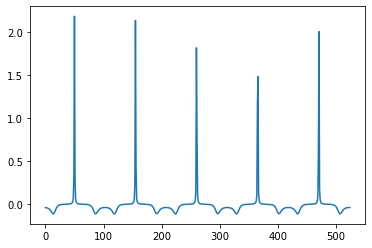

In [11]:
plt.plot(f)

In [12]:
duration = 10
dur_steps = int(duration * (1/ps.dt) * 1000)
signal = hilbert_trafo_nd(ue[-dur_steps:,:], axis=0)
phases = inst_phase(signal)

In [13]:
phases_cut = phases[-60000:-20000]
len(phases_cut.T)

526

In [14]:
from py.funcs import getSwitchIndex

phase_latencies = np.zeros(len(phases_cut.T))

for idx, node in enumerate(phases_cut.T):
    complex_vector = np.exp(1j * node)
    
    # Extract real and imaginary components of the complex vectors
    real_part = np.real(complex_vector)
    imaginary_part = np.imag(complex_vector)
    
    how_many_time_steps = getSwitchIndex(imaginary_part)
    #print(how_many_time_steps[0])
    phase_latencies[idx] = how_many_time_steps[0]



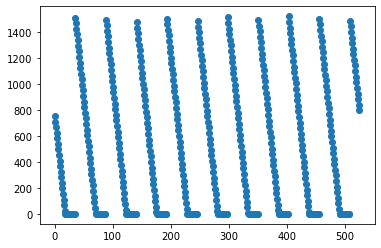

In [15]:
plt.scatter(np.linspace(0,ps.n-1, ps.n), phase_latencies, cmap=phase_latencies)

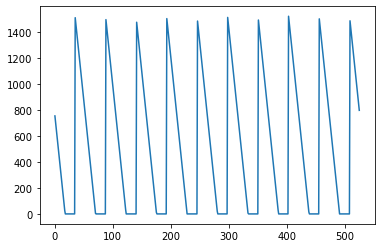

In [16]:
plt.plot(phase_latencies)

In [19]:
# explicit function to normalize array
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
 
# assign array and range
array_1d = phase_latencies
range_to_normalize = (0, 1)
normalized_array_1d = normalize(array_1d, range_to_normalize[0], range_to_normalize[1])

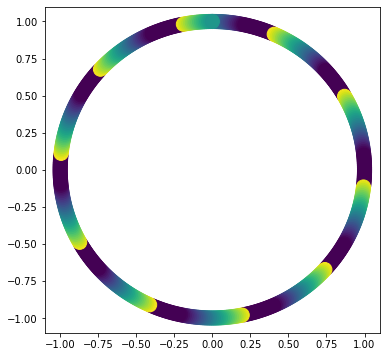

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(np.sin(np.linspace(0,2*np.pi, ps.n)),np.cos(np.linspace(0,2*np.pi, ps.n)), c=normalized_array_1d,
            s=200)

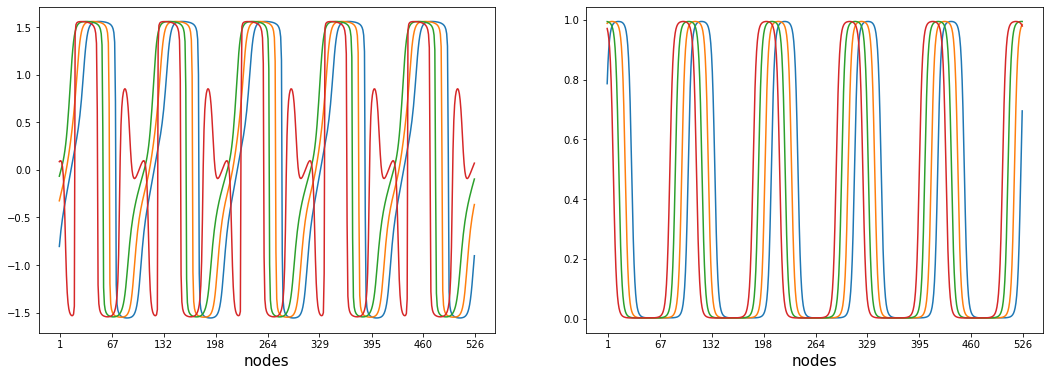

In [21]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(18,6))

for t in [-1000, -650, -300, -1]:
    ax0.plot(phases[t])
    ax1.plot(ue[t])

for ax in [ax0, ax1]:
    ax.set_xlabel('nodes', fontsize=15)
    ax.set_xticks(np.linspace(1,ps.n, 9).round(), fontsize=15)
    
    

Text(0.5, 0, 'time')

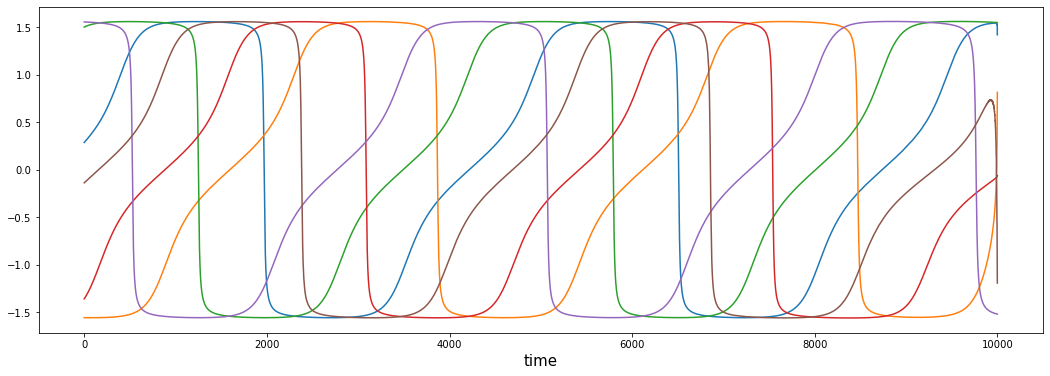

In [22]:
fig, ax = plt.subplots(1,1,figsize=(18,6))

for t in np.linspace(20, 325, 6).astype(int):
    ax.plot(phases.T[t, -10000:])

ax.set_xlabel('time', fontsize=15)

Text(0, 0.5, 'space')

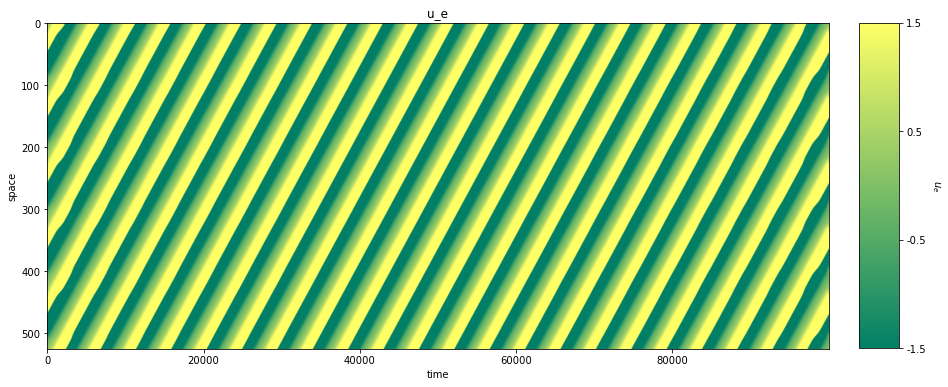

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

pos = ax.imshow(phases.T, vmin=-1.5, vmax=1.5, aspect='auto', cmap=cmap)
colors = ['black', 'dimgray', 'silver']

ax.set_title(label='u_e')

cbar_ticks=np.linspace(-1.5,1.5,4)
cb_ax = fig.add_axes([.93,.126,.04,.754])
cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel(r'$u_e$', rotation=-90, va="bottom")
cbar.ax.set_yticklabels([-1.5, -0.5, 0.5, 1.5])

ax.set_xlabel('time')
ax.set_ylabel('space')

In [57]:
ee = 0.85
ii = 0.27

params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 25*1000, 'mu_a': 0.4, 'beta_a': 10, 'n': 526, 'tau_a': 6000}

ps = setParams(params)
fps = computeFPs(ps)
stab = checkFixPtsStability(fps, ps)

k=np.linspace(-3,3,51)

a_ee, a_ei, a_ie, a_ii = a_jkValues(fps[-1], ps)

print('fixed points %s ' %str(fps))
print('with (mass) stability %s'  %str(stab))

fixed points [[0.11764133 0.62131853]
 [0.6610546  0.99957344]
 [0.99743213 0.99999834]] 
with (mass) stability [1, 0, 1]


In [58]:
fp = fps[0]
checkStability(k, fp, ps)

(1, 1, 0)

In [59]:
ue, ui = c1d.run(ps, itype='inte_adaptation', fp=fp)

In [60]:
fix_time_step = -1000
fix_space_node0 = 10
fix_space_node1 = 70
fix_space_node2 = 120
cmap = 'summer'

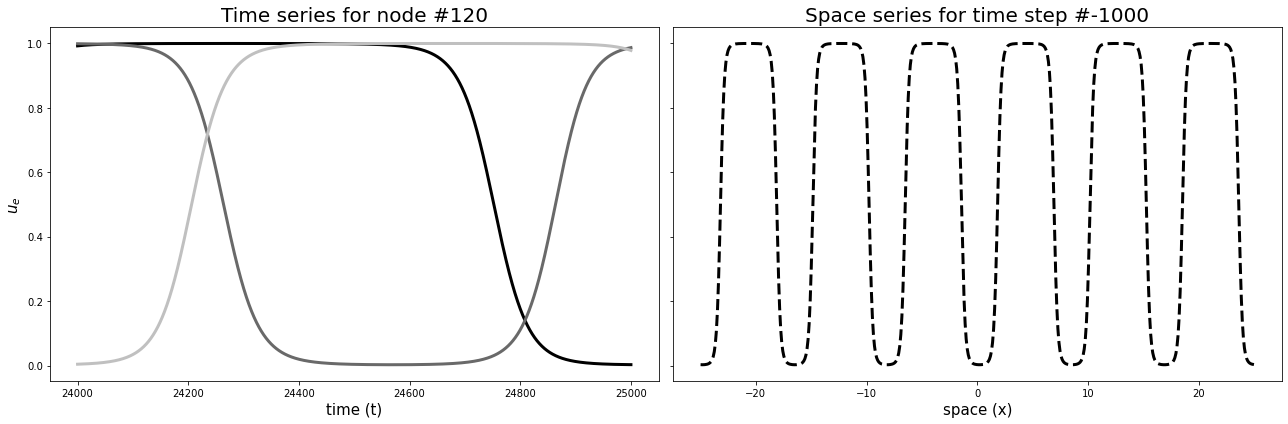

In [61]:
#plot cross section along one fix time-step and space step
space = np.linspace(-25, 25, len(ps.x))
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(18,6), sharey=True)

for idx, fix_space_node in enumerate([fix_space_node0, fix_space_node1, fix_space_node2]):
    ax0.plot(ps.time[-10000:], ue.T[fix_space_node,-10000:],
             c=colors[idx], ls='solid', lw=3)
ax1.plot(space, ue.T[:,fix_time_step],
         c='black', ls='dashed', lw=3)

ax0.set_title('Time series for node #%i' %fix_space_node, fontsize=20)
ax1.set_title('Space series for time step #%i' %fix_time_step, fontsize=20)

ax0.set_xlabel('time (t)', fontsize=15)
ax0.set_ylabel(r'$u_e$', fontsize=15)

ax1.set_xlabel('space (x)', fontsize=15)

plt.tight_layout()

Text(0, 0.5, 'space')

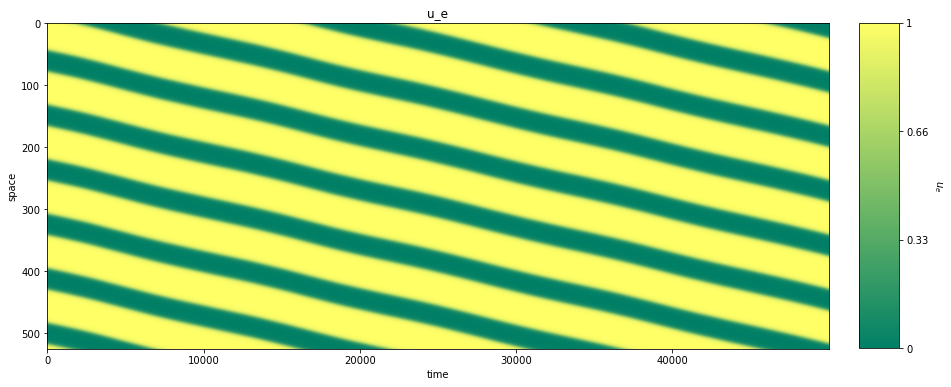

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

pos = ax.imshow(ue.T[:,-50000:], vmin=0, vmax=1, aspect='auto', cmap=cmap)
colors = ['black', 'dimgray', 'silver']

#for idx, fix_space_node in enumerate([fix_space_node0, fix_space_node1, fix_space_node2]):
#    ax.plot(np.linspace(fix_space_node, fix_space_node, len(ps.time)),
#            c=colors[idx], ls='solid', lw=3)
#ax.plot(np.linspace(ps.time[fix_time_step]*10, ps.time[fix_time_step]*10, len(ps.x)), 
#        np.linspace(0, ps.n-1, ps.n),
#        c='black', ls='dashed', lw=3)

ax.set_title(label='u_e')

cbar_ticks=np.linspace(0,1,4)
cb_ax = fig.add_axes([.93,.126,.04,.754])
cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel(r'$u_e$', rotation=-90, va="bottom")
cbar.ax.set_yticklabels([0, 0.33, 0.66, 1])

ax.set_xlabel('time')
ax.set_ylabel('space')

In [63]:
duration = 10
dur_steps = int(duration * (1/ps.dt) * 1000)
signal = hilbert_trafo_nd(ue[-dur_steps:,:], axis=0)
phases = inst_phase(signal)

Text(0.5, 0, 'time')

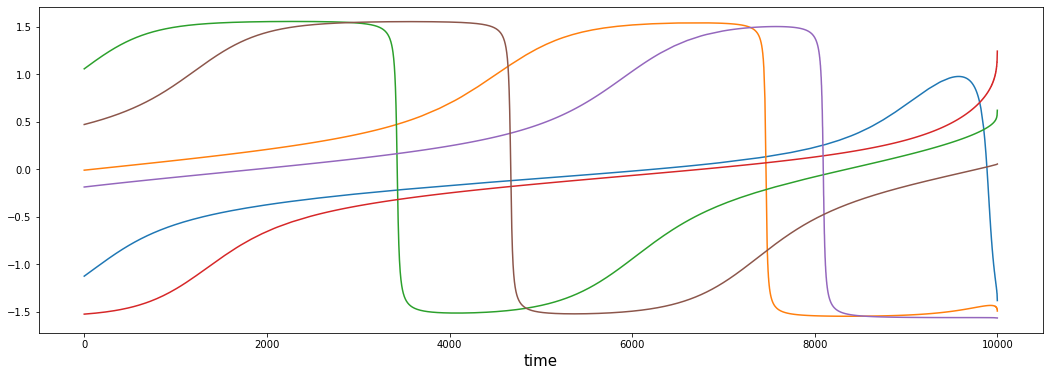

In [64]:
fig, ax = plt.subplots(1,1,figsize=(18,6))

for t in np.linspace(20, 325, 6).astype(int):
    ax.plot(phases.T[t, -10000:])

ax.set_xlabel('time', fontsize=15)
    
    

Text(0.5, 0, 'time')

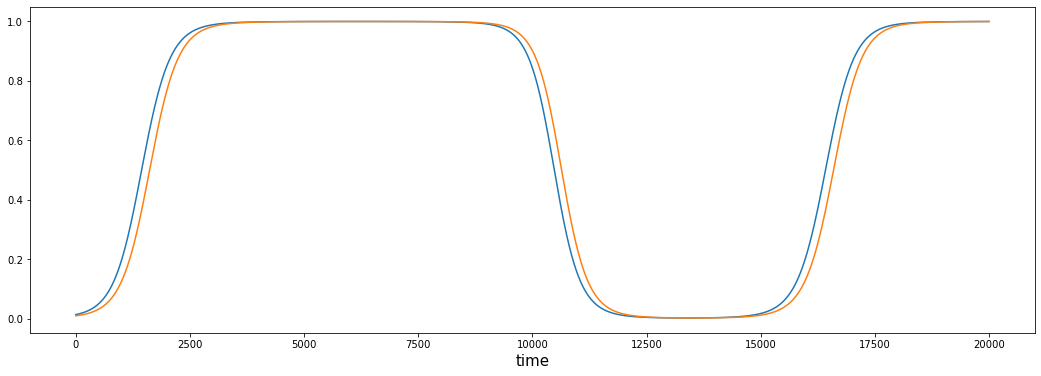

In [65]:
fig, ax = plt.subplots(1,1,figsize=(18,6))

for t in np.linspace(320, 321, 2).astype(int):
    ax.plot(ue.T[t, -20000:])

ax.set_xlabel('time', fontsize=15)

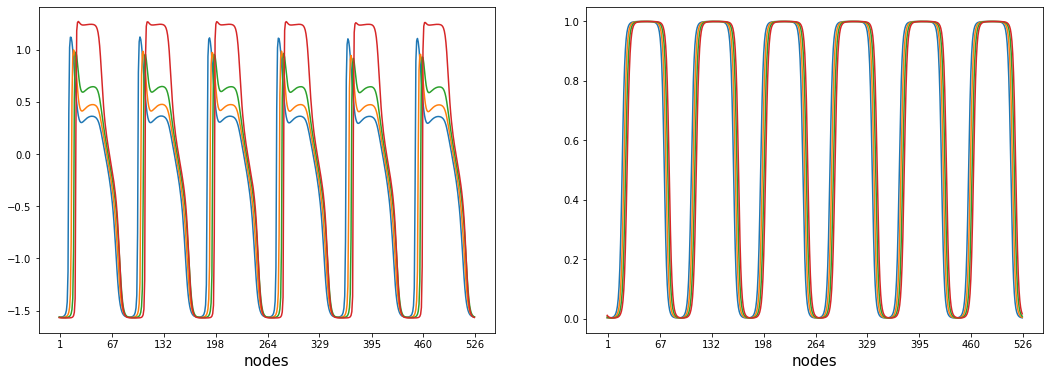

In [66]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(18,6))

for t in [-1000, -650, -300, -1]:
    ax0.plot(phases[t])
    ax1.plot(ue[t])

for ax in [ax0, ax1]:
    ax.set_xlabel('nodes', fontsize=15)
    ax.set_xticks(np.linspace(1,ps.n, 9).round(), fontsize=15)

Text(0, 0.5, 'space')

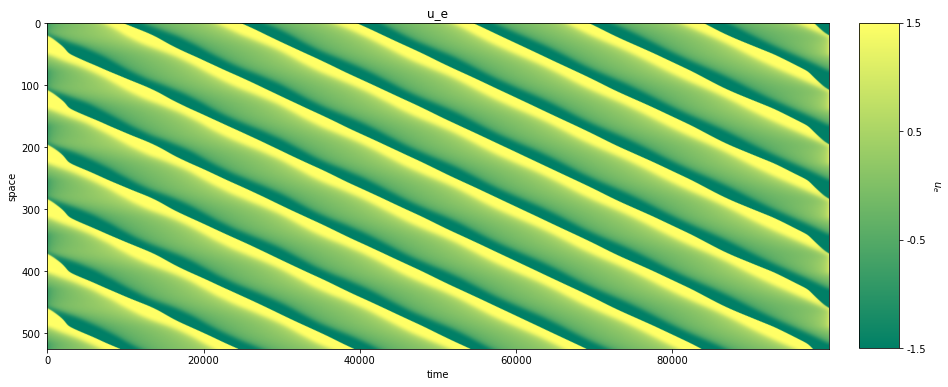

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

pos = ax.imshow(phases.T, vmin=-1.5, vmax=1.5, aspect='auto', cmap=cmap)
colors = ['black', 'dimgray', 'silver']

ax.set_title(label='u_e')

cbar_ticks=np.linspace(-1.5,1.5,4)
cb_ax = fig.add_axes([.93,.126,.04,.754])
cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel(r'$u_e$', rotation=-90, va="bottom")
cbar.ax.set_yticklabels([-1.5, -0.5, 0.5, 1.5])

ax.set_xlabel('time')
ax.set_ylabel('space')

In [69]:
duration = 10
dur_steps = int(duration * (1/ps.dt) * 1000)
signal = hilbert_trafo_nd(ue[-dur_steps:,:], axis=0)
phases = inst_phase(signal)

In [70]:
phases.shape

(100000, 526)

In [71]:
phases[0].shape

(526,)

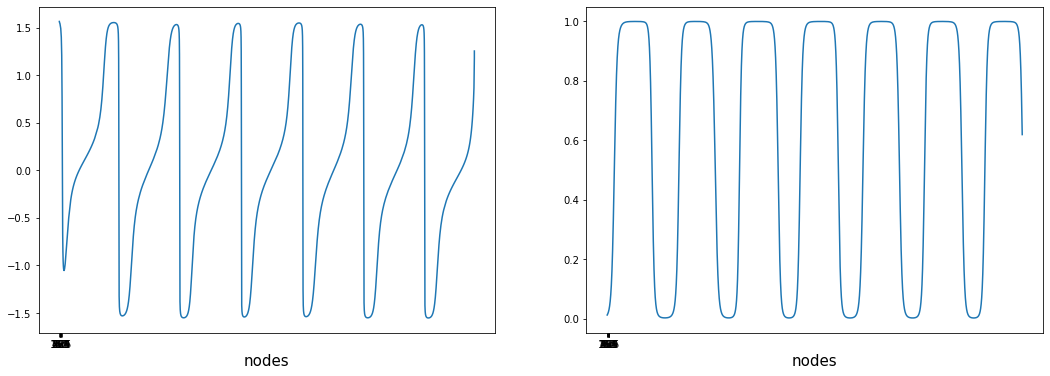

In [72]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(18,6))

for t in [-500]:
    ax0.plot(phases.T[t])
    ax1.plot(ue.T[-500,-dur_steps:])

for ax in [ax0, ax1]:
    ax.set_xlabel('nodes', fontsize=15)
    ax.set_xticks(np.linspace(1,ps.n, 9).round(), fontsize=15)
    
    

In [73]:
phases.shape

(100000, 526)

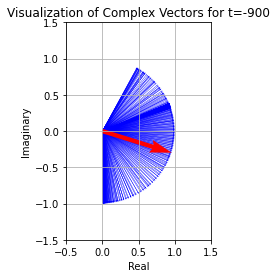

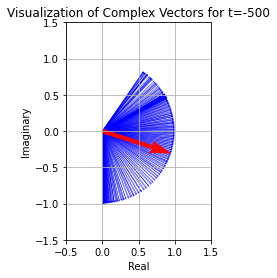

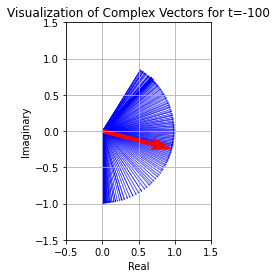

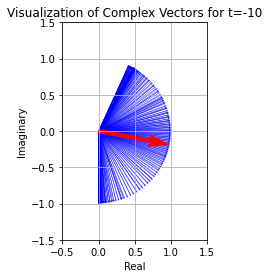

In [74]:
for t in [-900, -500, -100, -10]:
    
    #Visualisation below programmed with the help of ChatGPT
    # Instantaneous Phase is already the angles translated into radians:
    angles_radians = phases[t]
    
    # Create complex vectors from the angles
    complex_vectors = np.exp(1j * angles_radians)
    
    # Extract real and imaginary components of the complex vectors
    real_parts = np.real(complex_vectors)
    imaginary_parts = np.imag(complex_vectors)
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots()
    
    # Plot the vectors
    origin = np.zeros_like(angles_radians)  # Starting point for all vectors
    ax.quiver(origin, origin, real_parts, imaginary_parts, angles='xy', scale_units='xy', scale=1, color='b')
    
    #plot 'average phase'
    avg_radiant = np.mean(phases[t])
    # Create complex vector from the angles
    complex_vector = np.exp(1j * avg_radiant)
    # Extract real and imaginary components of the complex vectors
    real_part = np.real(complex_vector)
    imaginary_part = np.imag(complex_vector)
    
    ax.quiver(0, 0, real_part, imaginary_part, angles='xy', scale_units='xy', scale=1, color='r', width=0.03)
    
    # Set axis limits based on the vectors
    ax.set_xlim([-0.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    
    # Add labels to the vectors
    #for angle_deg, real, imag in zip(angles_degrees, real_parts, imaginary_parts):
    #    label = f"{angle_deg}°"
    #    ax.text(real, imag, label, ha='center', va='bottom')
    
    # Set axis labels
    ax.set_xlabel('Real')
    ax.set_ylabel('Imaginary')
    
    # Set axis aspect ratio to be equal
    ax.set_aspect('equal')
    
    # Set the title
    plt.title("Visualization of Complex Vectors for t=%i" %t)
    
    # Show the plot
    plt.grid()
    plt.show()

In [75]:
x = np.array([[0,1,2]])#, [3,4,5], [6,7,8]])
y = np.roll(x,-1)#, axis=0)
z = np.roll(x.T,-1, axis=0)
x,y,z.T

(array([[0, 1, 2]]), array([[1, 2, 0]]), array([[1, 2, 0]]))

In [76]:
phases_cut = phases[-60000:-30000]
len(phases_cut.T)

526

In [77]:
from py.funcs import getSwitchIndex

phase_latencies = np.zeros(len(phases_cut.T))

for idx, node in enumerate(phases_cut.T):
    complex_vector = np.exp(1j * node)
    
    # Extract real and imaginary components of the complex vectors
    real_part = np.real(complex_vector)
    imaginary_part = np.imag(complex_vector)
    
    how_many_time_steps = getSwitchIndex(imaginary_part)
    #print(how_many_time_steps[0])
    phase_latencies[idx] = how_many_time_steps[0]



In [78]:
#phase latency into ms
phase_latencies *=0.1
 
# assign array and range
array_1d = phase_latencies
range_to_normalize = (0, 1)
normalized_array_1d = normalize(array_1d, range_to_normalize[0], range_to_normalize[1])

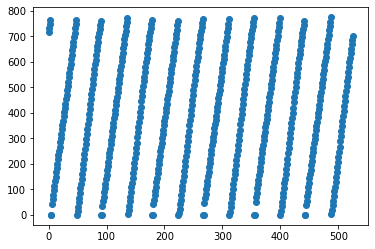

In [79]:
plt.scatter(np.linspace(0,ps.n-1, ps.n), phase_latencies, cmap=phase_latencies)

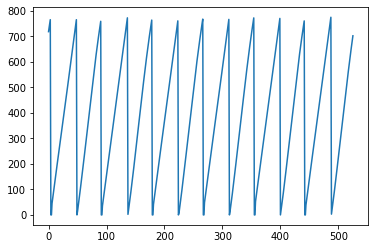

In [80]:
plt.plot(phase_latencies)

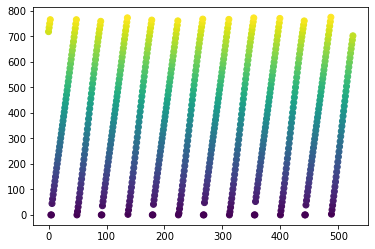

In [81]:
plt.scatter(np.linspace(0,ps.n-1, ps.n), phase_latencies, c=normalized_array_1d)

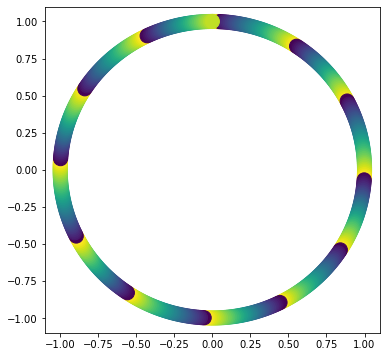

In [82]:
plt.figure(figsize=(6,6))
plt.scatter(np.sin(np.linspace(0,2*np.pi, ps.n)),np.cos(np.linspace(0,2*np.pi, ps.n)), c=normalized_array_1d,
            s=200)

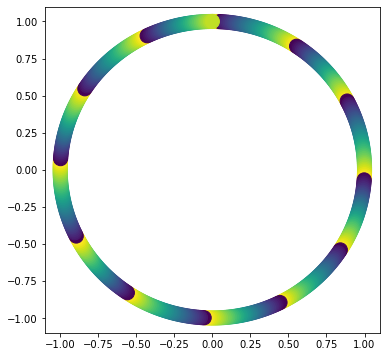

In [83]:
plt.figure(figsize=(6,6))
plt.scatter(np.sin(np.linspace(0,2*np.pi, ps.n)),np.cos(np.linspace(0,2*np.pi, ps.n)), c=normalized_array_1d,
            s=200)